In [1]:
import tensorflow as tf
print(tf.__version__)

2.7.0


In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import inception_v3
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input, GlobalAveragePooling2D, BatchNormalization, Activation
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.optimizers import Optimizer, Adam,RMSprop, SGD
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
#import argparse
import os
import math

In [3]:
data_train = np.load('new_3000_data_train_224.npy')
labels_train = np.load('new_3000_labels_train_224.npy')

In [4]:
#Shuffling Data
np.random.seed(12345)
indx=np.arange(data_train.shape[0])          
np.random.shuffle(indx)
data_train = data_train[indx]
labels_train = labels_train[indx]

In [5]:
labels = np.argmax(labels_train, axis=1)
labels.shape

(3000,)

In [6]:
from sklearn.metrics import roc_auc_score
from utils import roc_curv_plot
from utils import evaluation_metrics

In [7]:
from sklearn.model_selection import KFold, StratifiedKFold
skf = StratifiedKFold(n_splits = 5, random_state = 7, shuffle = True)

19/19 [==============================] - 9s 108ms/step - loss: 12.0366 - acc: 0.9583
[12.036606788635254, 0.9583333134651184]
[INFO] evaluating network...Fold: 1
              precision    recall  f1-score   support

       covid       0.96      0.92      0.94       200
      normal       0.93      0.96      0.94       200
       viral       0.99      1.00      1.00       200

    accuracy                           0.96       600
   macro avg       0.96      0.96      0.96       600
weighted avg       0.96      0.96      0.96       600



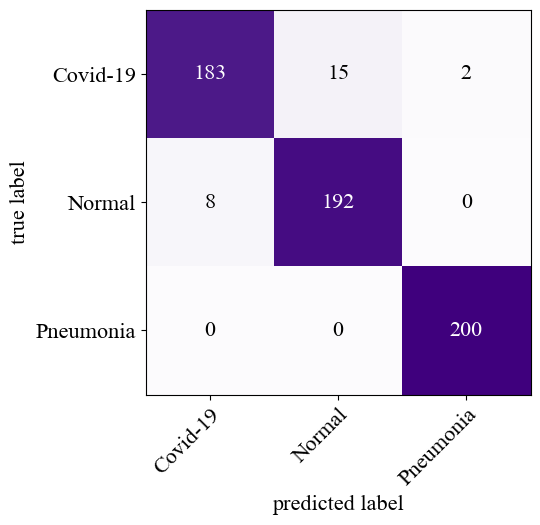

<Figure size 640x480 with 0 Axes>

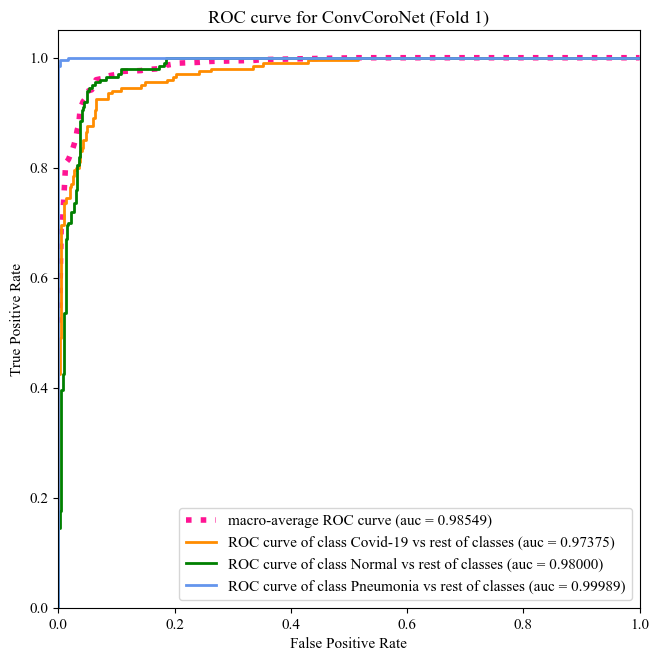

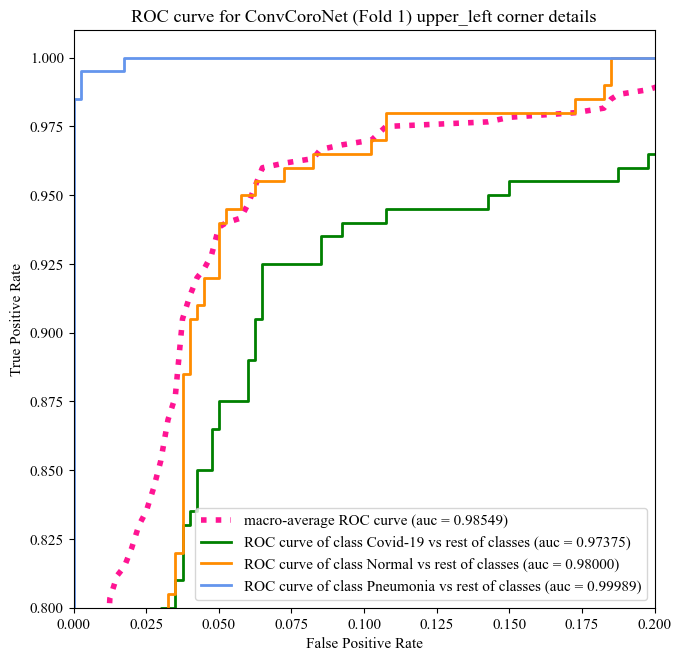

<Figure size 640x480 with 0 Axes>

score fold 1: 0.9845458333333333
19/19 [==============================] - 3s 57ms/step - loss: 12.0793 - acc: 0.9367
[12.079318046569824, 0.9366666674613953]
[INFO] evaluating network...Fold: 2
              precision    recall  f1-score   support

       covid       0.90      0.92      0.91       200
      normal       0.92      0.90      0.91       200
       viral       0.99      0.99      0.99       200

    accuracy                           0.94       600
   macro avg       0.94      0.94      0.94       600
weighted avg       0.94      0.94      0.94       600



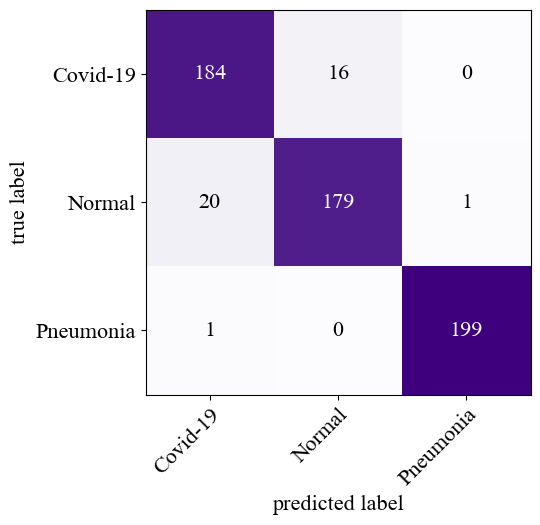

<Figure size 640x480 with 0 Axes>

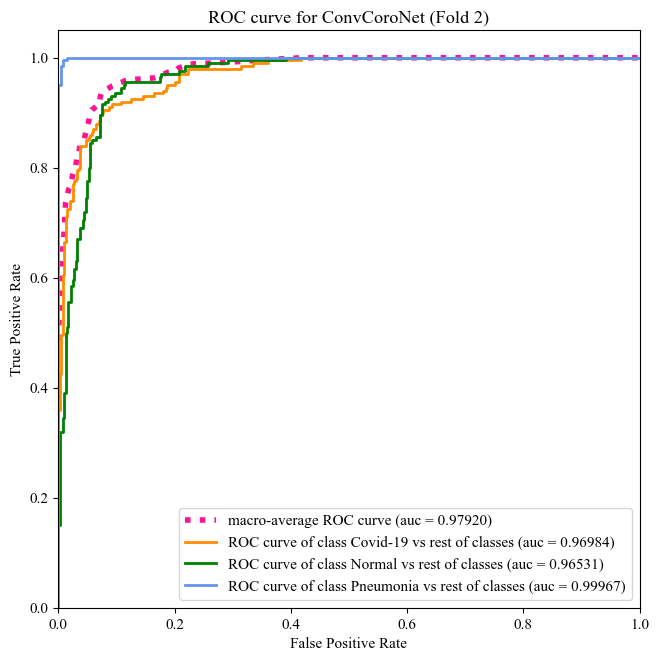

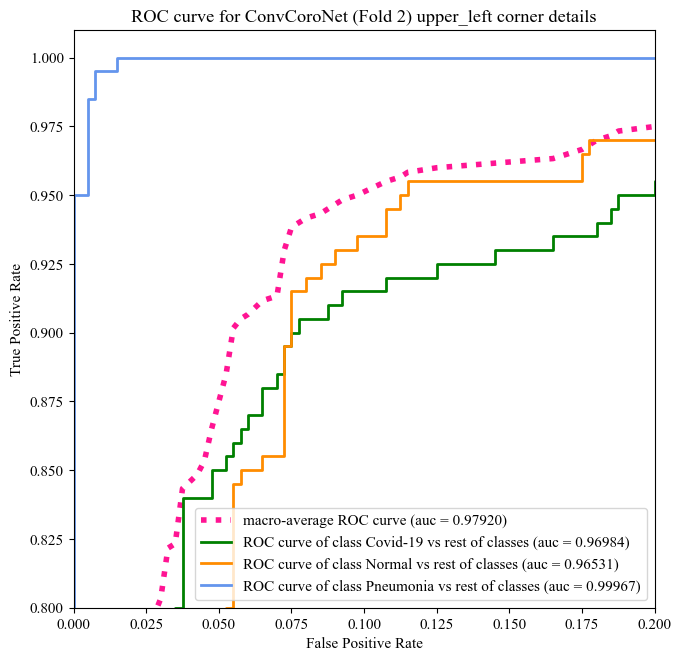

<Figure size 640x480 with 0 Axes>

score fold 2: 0.978275
19/19 [==============================] - 4s 57ms/step - loss: 12.0998 - acc: 0.9400
[12.09979248046875, 0.9399999976158142]
[INFO] evaluating network...Fold: 3
              precision    recall  f1-score   support

       covid       0.89      0.93      0.91       200
      normal       0.94      0.90      0.92       200
       viral       0.99      0.99      0.99       200

    accuracy                           0.94       600
   macro avg       0.94      0.94      0.94       600
weighted avg       0.94      0.94      0.94       600



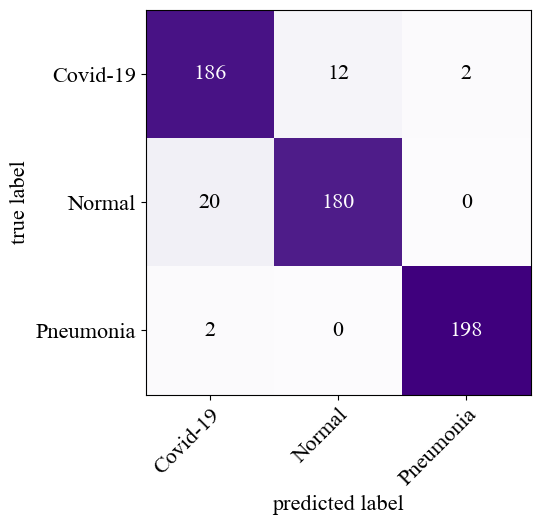

<Figure size 640x480 with 0 Axes>

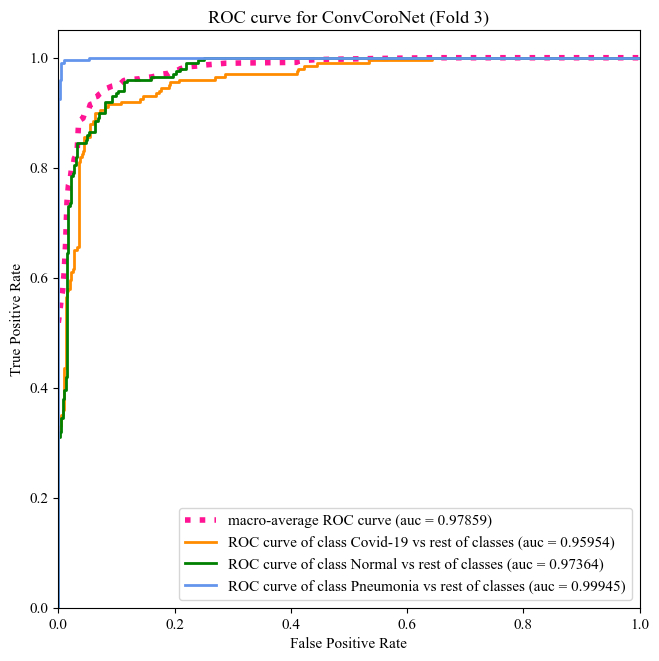

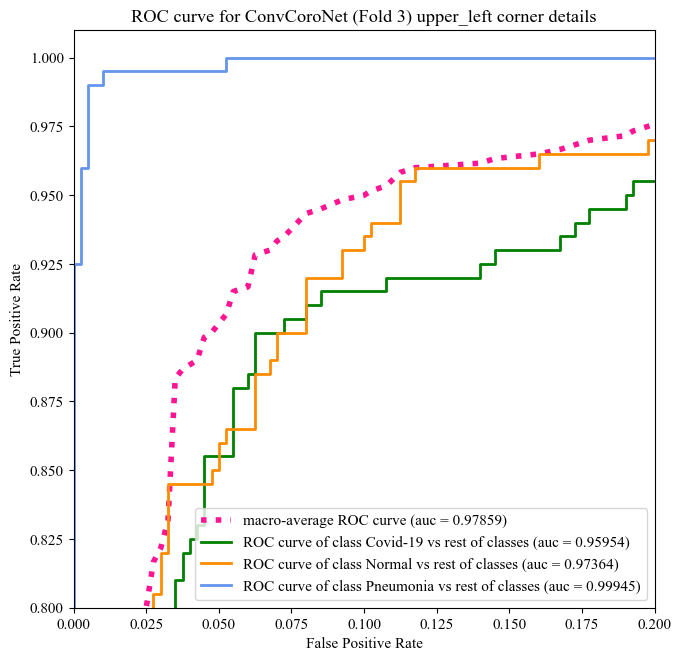

<Figure size 640x480 with 0 Axes>

score fold 3: 0.9775416666666666
19/19 [==============================] - 3s 57ms/step - loss: 12.0486 - acc: 0.9450
[12.048559188842773, 0.9449999928474426]
[INFO] evaluating network...Fold: 4
              precision    recall  f1-score   support

       covid       0.93      0.91      0.92       200
      normal       0.91      0.94      0.92       200
       viral       0.99      0.99      0.99       200

    accuracy                           0.94       600
   macro avg       0.95      0.94      0.94       600
weighted avg       0.95      0.94      0.94       600



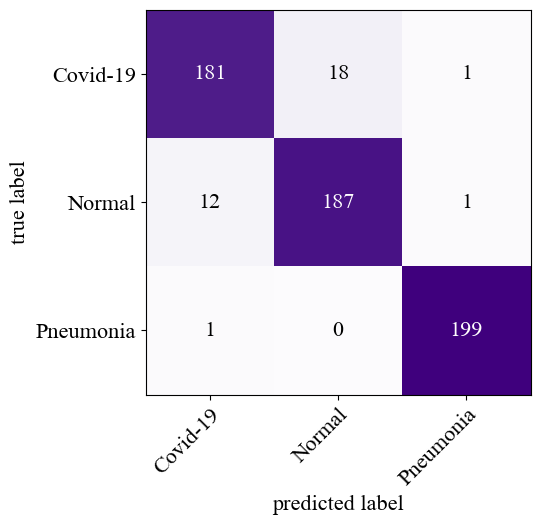

<Figure size 640x480 with 0 Axes>

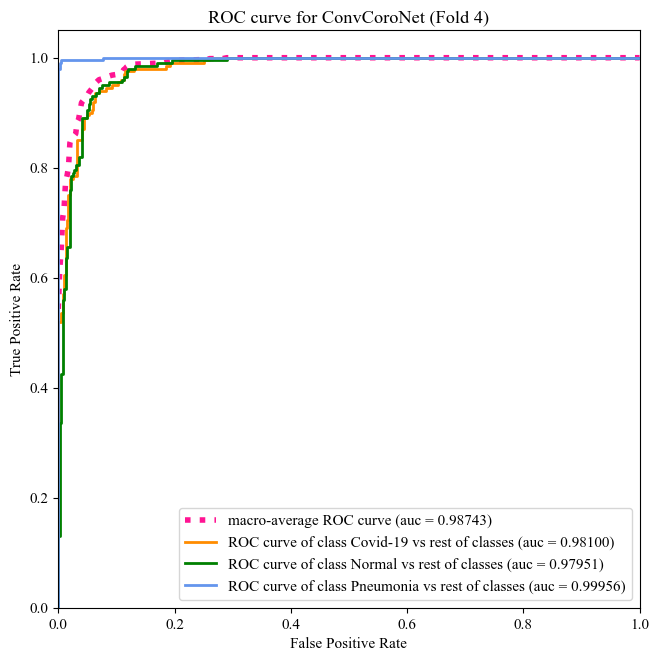

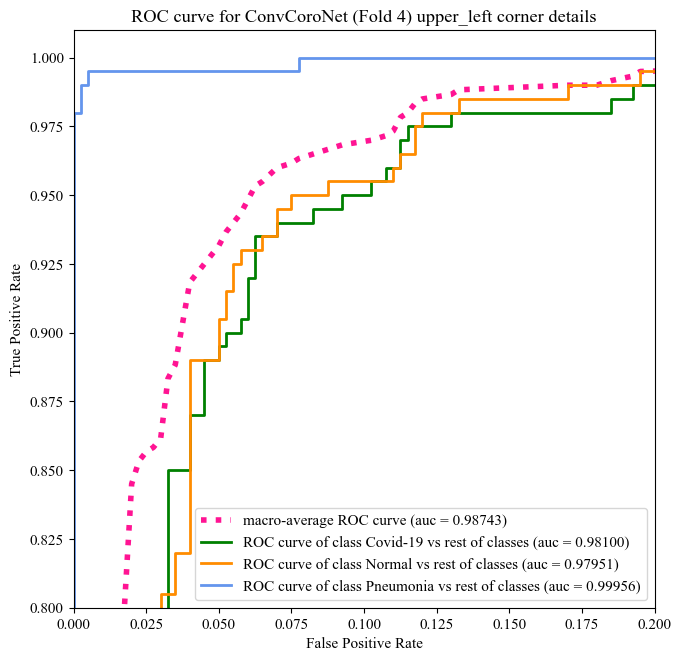

<Figure size 640x480 with 0 Axes>

score fold 4: 0.9866916666666666
19/19 [==============================] - 3s 58ms/step - loss: 12.0584 - acc: 0.9450
[12.058416366577148, 0.9449999928474426]
[INFO] evaluating network...Fold: 5
              precision    recall  f1-score   support

       covid       0.96      0.88      0.91       200
      normal       0.88      0.96      0.92       200
       viral       1.00      1.00      1.00       200

    accuracy                           0.94       600
   macro avg       0.95      0.94      0.94       600
weighted avg       0.95      0.94      0.94       600



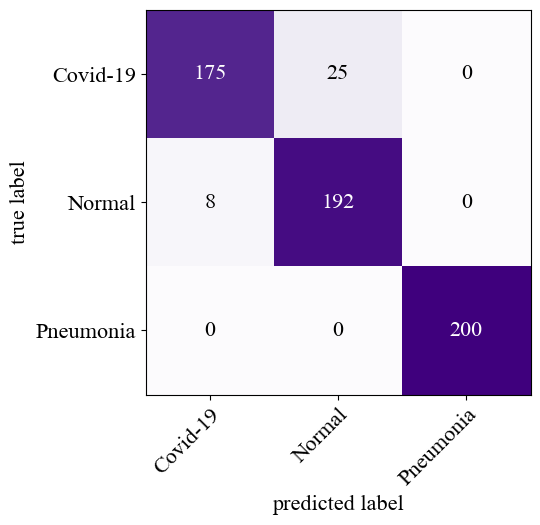

<Figure size 640x480 with 0 Axes>

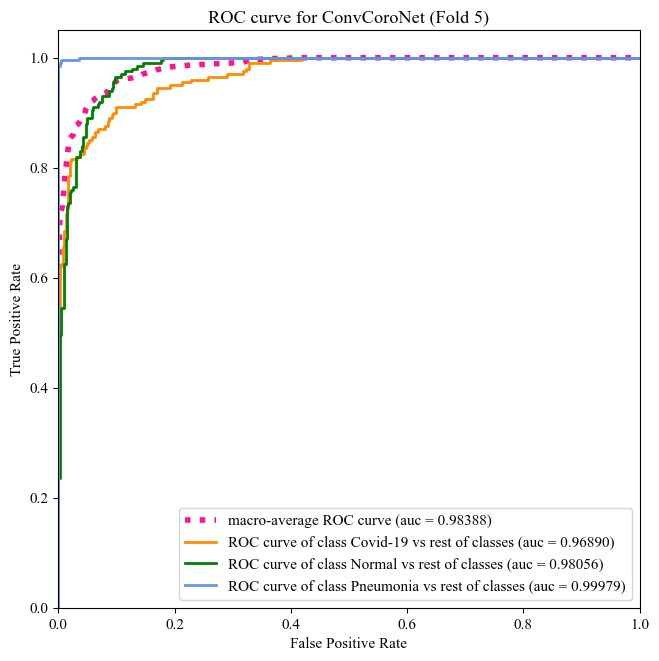

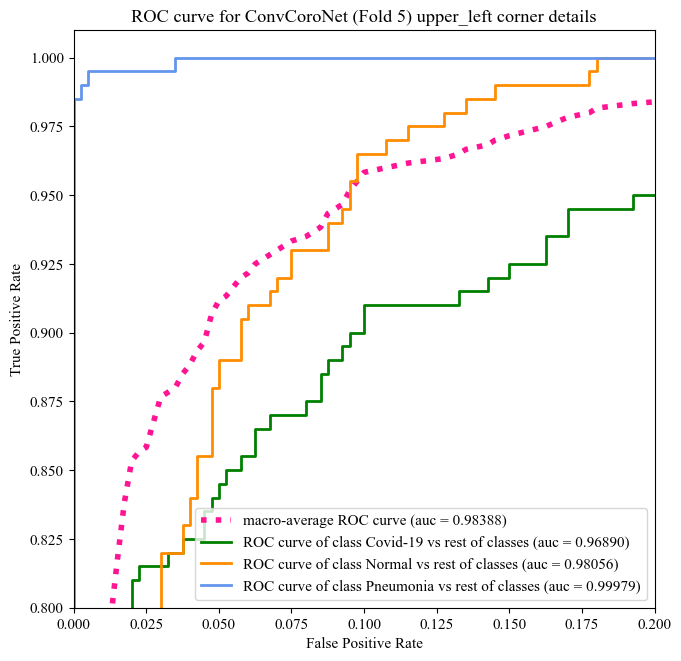

<Figure size 640x480 with 0 Axes>

score fold 5: 0.9830833333333334
Average AUC: 0.9820275


In [8]:
#base_model_opt = "InceptionV3_Adam"
#opt = Adam()

#base_model_opt = "InceptionV3_SGD"
#opt = SGD()

#base_model_opt = "InceptionV3_RMSprop"
#opt = RMSprop()

#For InceptionV3 + SVM (SGD optimizer)
base_model_opt = "InceptionV3_SVM"
opt = SGD()

save_dir = 'covid19_models_cross_val_' + base_model_opt +'/' # A base directory to save results and models


fold_var = 1
aucs = 0.0

tf.keras.backend.clear_session()
for train_index, val_index in skf.split(np.zeros(len(data_train)),labels):
  
    training_data = data_train[train_index]
    training_labels = labels_train[train_index]
    validation_data = data_train[val_index]
    validation_labels = labels_train[val_index]
  
    model = load_model(save_dir + 'model_' + base_model_opt + '_fold_' + str(fold_var) + '.h5', compile=False)
    
    #model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["acc"])
    model.compile(loss="categorical_hinge", optimizer=opt, metrics=["acc"]) # For InseptionV3 + SVM as classifier
   
    print(model.evaluate(validation_data, validation_labels))
  
    evaluation_metrics(model, validation_data, validation_labels, fold_var, 32)
    
    predIdxs = model.predict(validation_data, batch_size=32)
  
    plt.figure()
    plt.show()
  
    roc_curv_plot(validation_labels, predIdxs, fold_var)
  
    plt.figure()
    plt.show()
  
    auc = roc_auc_score(validation_labels, predIdxs, multi_class='ovr', average='macro')
    aucs = aucs + auc
    print("score fold " + str(fold_var) + ": " + str(auc))
    
    tf.keras.backend.clear_session()
      
    fold_var = fold_var + 1
aucs = np.array(aucs)
print("Average AUC: " + str(aucs/5.0))

In [9]:
print("Average AUC: " + str(aucs/5.0))

Average AUC: 0.9820275
